<a href="https://colab.research.google.com/github/kmkarakaya/Deep-Learning-Tutorials/blob/master/Save_Load_Keras_Models_with_Custom_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to save and load a TensorFlow / Keras Model with Custom Objects?

**Author:** [Murat Karakaya](https://www.linkedin.com/in/muratkarakaya/)<br>
**Date created:** 30 May 2021<br>
**Last modified:** 06 Jun 2021<br>
**Description:** In this tutorial, we will design and train a **Keras  model** (miniature GPT3) with some **custom objects** (***custom layers***). Our aim is to learn how to **save** the **trained model** as a whole and **load** the saved model. We will learn 2 different save formats: "**TensorFlow SevedModel**" & "**HDF5**".  <br>
**Accessible on:**
* [YouTube in English]()
* [YouTube in Turkish]()
* [Medium](https://kmkarakaya.medium.com/save-load-keras-models-with-custom-layers-8f55ba9183d2)
* [Github pages](https://kmkarakaya.github.io/Deep-Learning-Tutorials/)
* [Github Repo](https://github.com/kmkarakaya/Deep-Learning-Tutorials)
* [Google Colab](https://colab.research.google.com/drive/1gfvcXwBDel8USWuMeb-hrSKihXGy_bSl?usp=sharing)





# References:
[Keras API reference / Callbacks API / ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)

[ Keras API reference / Models API / Model saving & serialization APIs](https://keras.io/api/models/model_saving_apis/)


[TensorFlow Core Tutorials: Save and load models](https://www.tensorflow.org/tutorials/keras/save_and_load)


[TensorFlow Core Tutorials: Saving custom objects](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects)

[Saving Keras models with Custom Layers](https://newbedev.com/saving-keras-models-with-custom-layers)


# Import Libraries

In [ ]:
import numpy as np 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import random

# Check Versions

In [ ]:
#@title Versions:
print("tf.version: ", tf.version.VERSION)
print("tf.keras.version: ", tf.keras.__version__)

tf.version:  2.5.0
tf.keras.version:  2.5.0


# Let me ask you: Have you ever used a custom layer / loss function / activation function / metric?

If you have ever implemented one of these ***please share your experiences*** in the comments. 

I wonder if you feel confortable with somehow these advanced topics that I work on.

**Thank you!**

# What to save:

We can save either:
* [the entire model](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) or
* [the architecture](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_the_architecture) or
* [the weights](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_loading_only_the_models_weights_values)

In this tutorial, I will focus on how to save the **whole** TensorFlow / Keras models **with custom objects**, e.g. custom layers, custom activation functions, custom loss functions.

I will not talk about the *checkpoint* process in this tutorial.





# What do we save when we save the whole model?

We can save an **entire model** to a single artifact. 

[It will include](https://www.tensorflow.org/guide/keras/save_and_serialize#whole-model_saving_loading):

* The model's ***architecture/config***
* The model's ***weight*** values (which were learned during training)
* The model's ***compilation*** information (if compile() was called)
* The ***optimizer*** and its state, if any (this **enables** you to **resume training** where you left)



# Why do we save the whole TensorFlow & Keras Models?

Saving a **fully-functional model** is [very useful](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
* You can load them in TensorFlow.js and then train and run them in web browsers, or 
* You can convert them to run on mobile devices using TensorFlow Lite. 
* Furthermore, you do not need the model's "***Python code***" for inference.  
* In addition, you can **resume training** where you left when saved the model.

# What are the Save Formats in TensorFlow / Keras?

We have 2 model save formats: 
* Either  Tensorflow SavedModel or
* HDF5


**Defaults:**
* for TF 2.X is  **Tensorflow SavedModel** 
* for TF 1.X is  **HDF5**



# Which save format should I use?

In a nut's shell, I **strongly suggest** to use the **TensorFlow SavedModel** format to ***save the entire model***.

Do not use the H5 format unless you have a good reason!



# Why should I use the TensorFlow SavedModel format?
According to [Tensorflow Guide (2.5 or higher)](https://www.tensorflow.org/guide/keras/save_and_serialize#limitations); 

The **H5** format ***does not include*** two things that are saved by
 the **TF SavedModel** format:

* **External losses & metrics** added via model.add_loss() & model.add_metric() are **not saved**(**unlike SavedModel**). 

  If you have such losses & metrics on your model and you want to resume training, you need to add these losses back yourself after loading the model. Note that this does not apply to losses/metrics created inside layers via self.add_loss() & self.add_metric(). As long as the layer gets loaded, these losses & metrics are kept, since they are part of the call method of the layer.

* The computation graph of custom objects such as **custom layers** is **not included** in the saved file. At loading time, Keras will need access to the Python classes/functions of these objects in order to reconstruct the model. See Custom objects.

The buttom line is that "[the SavedModel format saves and loads *custom layers* without the original class definition](https://keras.io/api/models/model_saving_apis/)"

If you want to learn more about this property, look for the [save_traces]((https://keras.io/api/models/model_saving_apis/)) parameter.

I will show below how to save models with custom objects when saved in the H5 format.

# Which methods / functions to use to save the entire TensorFlow / Keras Models?

You can use:
* A Keras model's `model.save()` method or
* TensorFlow's `tf.keras.models.save_model()` method


# How to instruct the method to save in which format?

In both methods:
* if you only supply the name of the saved model, e.g. `model.save('my_model')`, then the saved model format will be **TF savedmodel** as ***default***.

* If you supply the H5 file extension,  e.g. `model.save('my_model.h5')`, then the saved model format will be **HDF5**.

# Create a Keras Model with custom objects ( custom layers)

## First, prepare the random train dataset:

In [ ]:
maxlen = 20
vocab_size = 100
number_of_categories = 20
rawdata = random.randint(vocab_size, size=(200, maxlen+1))
X = rawdata[:,:-1]
c = random.randint(number_of_categories, size=(200,1))
y = rawdata[:,1:]

## Then, build a TensorFlow Data Pipeline:

In [ ]:
train_ds= tf.data.Dataset.from_tensor_slices((X,c,y))
train_ds.element_spec

(TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 TensorSpec(shape=(1,), dtype=tf.int64, name=None),
 TensorSpec(shape=(20,), dtype=tf.int64, name=None))

In [ ]:
def re_struct(X,c,y):
  return (X,c),y
train_ds = train_ds.map(re_struct)

In [ ]:
batch_size=64
train_ds=train_ds.batch(batch_size=batch_size,drop_remainder=True, 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds=train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(64, 20), dtype=tf.int64, name=None),
  TensorSpec(shape=(64, 1), dtype=tf.int64, name=None)),
 TensorSpec(shape=(64, 20), dtype=tf.int64, name=None))

In [ ]:
for (X,c), y in train_ds.take(1):
  print(X.shape, c.shape, y.shape)
  print("\nFirst sample in the batch:")
  print("\tX is: " ,X[0])
  print("\tc is: ", c[0])
  print("\ty is: ", y[0])



(64, 20) (64, 1) (64, 20)

First sample in the batch:
	X is:  tf.Tensor([33 14 43 81 91 13 35 75 34 53 35 86 95  3 50 79 79 20 84 71], shape=(20,), dtype=int64)
	c is:  tf.Tensor([16], shape=(1,), dtype=int64)
	y is:  tf.Tensor([14 43 81 91 13 35 75 34 53 35 86 95  3 50 79 79 20 84 71 30], shape=(20,), dtype=int64)


## Design a Miniature GPT3 Model with custom layers

For more information you can visit the Controllable Text Generation tutorial series on Youtube ( [Turkish](https://www.youtube.com/playlist?list=PLQflnv_s49v8-xeTLx1QmuE-YkRB4bToF) / [English](https://www.youtube.com/playlist?list=PLQflnv_s49v8Eo2idw9Ju5Qq3JTEF-OFW)) or on [Medium](https://medium.com/deep-learning-with-keras/controllable-text-generation-in-deep-learning-with-transformers-gpt3-using-tensorflow-keras-3d9e6bbe243b).




In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

**Pay Attention:**
* We define **the first custom layer** `TransformerBlock()`

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__()
        self.embed_dim=embed_dim
        self.num_heads = num_heads
        self.ff_dim =ff_dim
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

* and  **the second custom layer** `TokenPositionAndCategoricalEmbedding()`

In [ ]:
class TokenPositionAndCategoricalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, number_of_categories, embed_dim, **kwargs):
        super(TokenPositionAndCategoricalEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.number_of_categories = number_of_categories
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.category_emb = layers.Embedding(input_dim=number_of_categories, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, X, c):
        maxlen = tf.shape(X)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        X = self.token_emb(X)
        c= self.category_emb(c)
        return X + positions + c

## Now, we can use these custom layers to build the Keras model as follows:

In [ ]:
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs_tokens = layers.Input(shape=(maxlen,), dtype=tf.int32)
    inputs_category = layers.Input(shape=(1,), dtype=tf.int32, name="inputs_category")
    # the first custom layer for embedding 
    embedding_layer = TokenPositionAndCategoricalEmbedding(maxlen, vocab_size, 
                                                           number_of_categories, 
                                                           embed_dim)
    x = embedding_layer(inputs_tokens,inputs_category)
    # the second custom layer for GPT-kind-of transformer decoder block
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=[inputs_tokens,inputs_category], outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model
my_model=create_model()

## Let's see the model summary & plot:

In [ ]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
inputs_category (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_position_and_categorical_ (None, 20, 256)      35840       input_1[0][0]                    
                                                                 inputs_category[0][0]            
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 20, 256)      658688      token_position_and_categorica

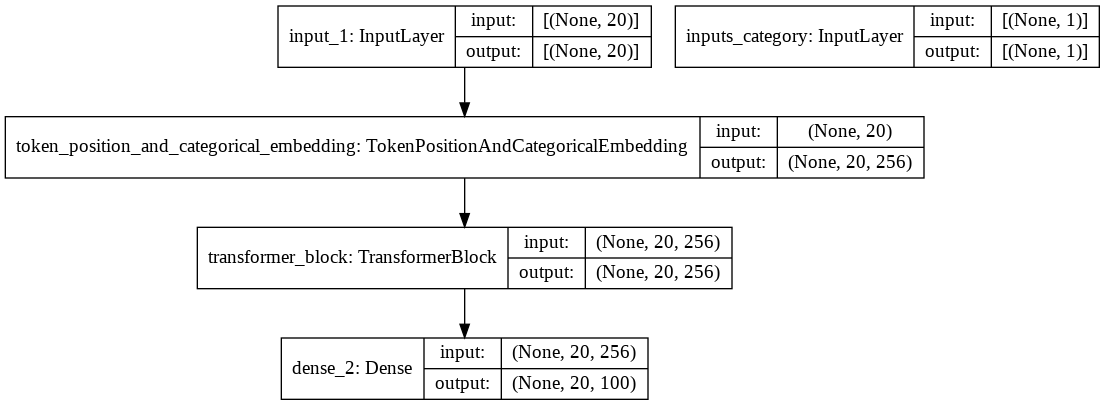

In [ ]:
tf.keras.utils.plot_model(my_model,show_shapes=True)

## Train the Keras model with custom layers for 3 epochs:

In [ ]:
my_model.fit(train_ds, verbose=1, epochs=3)

Epoch 1/3
3/3 [==============================] - 2s 134ms/step - loss: 5.2299 - dense_2_loss: 5.2299
Epoch 2/3
3/3 [==============================] - 0s 133ms/step - loss: 4.6296 - dense_2_loss: 4.6296
Epoch 3/3
3/3 [==============================] - 0s 133ms/step - loss: 4.3426 - dense_2_loss: 4.3426


## Let's fix a test sample

In [ ]:
test=train_ds.take(1)

Please note the the prediction of the trained model to check if the trained model and saved model have the same weights:

In [ ]:
my_model.predict(test)[0][0][0][0]

0.254973

# Saving custom objects with HDF5 format

According to the [TensorFlow Core Tutorials: Saving custom objects with HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) 

To save custom objects to HDF5, you must do the following:

1. Define a `get_config()` method in your object, and optionally a from_config class method.
* `get_config(self)` returns a JSON-serializable dictionary of parameters needed to recreate the object.
* `from_config(cls, config)` uses the returned config from get_config to create a new object. **By default**, this function will use the config as initialization kwargs (return cls(**config)).

2. Pass the object to the custom_objects argument when loading the model. The argument must be a dictionary mapping the string class name to the Python class. E.g.

 `tf.keras.models.load_model(path, custom_objects={'CustomLayer': CustomLayer})`


**Note that:** In the above custom layer we **have not implemented** `get_config()` method. Therefore, if we try to save the trained model with the custom layers, we will get the following **error** messages:

In [ ]:
#tf.keras.models.save_model(my_model, './saved_models/my_h5_model.h5')
my_model.save('./saved_models/my_h5_model.h5')

NotImplementedError: ignored

I will show **how to fix this error** after seeing TensorFlow SavedModel example.


# Saving custom objects with the TensorFlow SavedModel  format

## First call one of two methods to save the trained model in the TensorFlow SavedModel  format.

To do so, just give the fine name `my_tf_model` without any file extension!

In [ ]:
#tf.keras.models.save_model(my_model, './saved_models/my_tf_model')
my_model.save('./saved_models/my_tf_model')

INFO:tensorflow:Assets written to: ./saved_models/my_tf_model/assets


INFO:tensorflow:Assets written to: ./saved_models/my_tf_model/assets


As you observe, ***without any errors***, we are able to save the model with **custom objects**. 

Let's **load** the saved model as follows:

In [ ]:
my_tf_saved_model = tf.keras.models.load_model(
    './saved_models/my_tf_model')
my_tf_saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
inputs_category (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_position_and_categorical_ (None, 20, 256)      35840       input_1[0][0]                    
                                                                 inputs_category[0][0]            
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 20, 256)      658688      token_position_and_categorica

Run the `predict()` method of the loaded model on the same test sample an d compare the **predicted value**: 

In [ ]:
print("my_model.predict: ", my_model.predict(test)[0][0][0][0])
print("my_tf_saved_model.predict: ", my_tf_saved_model.predict(test)[0][0][0][0])

my_model.predict:  0.254973
my_tf_saved_model.predict:  0.254973


That's it: We **successfully** save and load the entire Keras model with custom layers in the TensorFlow SavedModel format.  

# Fix the error occurred when saving custom objects with HDF5 format

As suggested by the official TensorFlow documents, we need to add `get_config()` method to the custom objects! 

**Pay Attention that:**
* We re-define **thr custom layers** `TransformerBlock()` & `TokenPositionAndCategoricalEmbedding` by adding `get_config()` which defines the inputs and internal variables of the custom layer as below.  

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__()
        self.embed_dim=embed_dim
        self.num_heads = num_heads
        self.ff_dim =ff_dim
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2':self.layernorm2,
            'dropout1':self.dropout1,
            'dropout2':self.dropout2,
            'embed_dim': self.embed_dim,
            'num_heads':self.num_heads,
            'ff_dim':self.ff_dim 

        })
        return config

In [ ]:
class TokenPositionAndCategoricalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, number_of_categories, embed_dim, **kwargs):
        super(TokenPositionAndCategoricalEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.number_of_categories = number_of_categories
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.category_emb = layers.Embedding(input_dim=number_of_categories, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, X, c):
        maxlen = tf.shape(X)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        X = self.token_emb(X)
        c= self.category_emb(c)
        return X + positions + c
        
       
    def get_config(self):
        config = super(TokenPositionAndCategoricalEmbedding, self).get_config()
        config.update({
            'token_emb': self.token_emb,
            'category_emb':self.category_emb,
            'pos_emb': self.pos_emb,
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'number_of_categories':self.number_of_categories,
            'embed_dim': self.embed_dim
        })
        return config

## Re-build the model after these updates:


In [ ]:
my_model=create_model()

## Train the new model:

In [ ]:
my_model.fit(train_ds, verbose=1, epochs=3)

Epoch 1/3
3/3 [==============================] - 2s 142ms/step - loss: 5.2268 - dense_5_loss: 5.2268
Epoch 2/3
3/3 [==============================] - 0s 137ms/step - loss: 4.6378 - dense_5_loss: 4.6378
Epoch 3/3
3/3 [==============================] - 0s 132ms/step - loss: 4.3475 - dense_5_loss: 4.3475


## Save the trained model in the H5 format

In [ ]:
#tf.keras.models.save_model(my_model, './saved_models/my_h5_model.h5')
my_model.save('./saved_models/my_h5_saved_model.h5')

**Notice that:** This time, we did not receive any error messages!

## Now, load the saved model in the H5 format by providing custom object names as below:

In [ ]:
my_h5_saved_model = tf.keras.models.load_model(
    './saved_models/my_h5_saved_model.h5', 
    custom_objects={'TransformerBlock': TransformerBlock,
                    'TokenPositionAndCategoricalEmbedding':TokenPositionAndCategoricalEmbedding})
my_h5_saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
inputs_category (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_position_and_categorical_ (None, 20, 256)      35840       input_2[0][0]                    
                                                                 inputs_category[0][0]            
__________________________________________________________________________________________________
transformer_block_2 (Transforme (None, 20, 256)      658688      token_position_and_categori

Run the `predict()` method of the loaded model on the same test sample and compare the **predicted value**: 

In [ ]:
print("my_model.predict: ", my_model.predict(test)[0][0][0][0])
print("my_h5_saved_model.predict: ", my_h5_saved_model.predict(test)[0][0][0][0])

my_model.predict:  -0.11366672
my_h5_saved_model.predict:  -0.11366672


Yes, we **successfully** save and load the entire Keras model with custom layers in the **H5** format as well.

**Note that:** You can also **resume training** the loaded models. 

Please try it by yourself :)

# Conclusions:
* We reviewed the related concepts to **save and load** a ***Keras model with custom objects*** in TensorFlow.
* We have **implemented** custom objects (layers) in a Keras model.
* We **saved** the entire trained model with **2 different formats**: `TensorFlow SavedModel` & `HDF5`.
* We **loaded** the saved model successfully and use it for prediction.
* If you do not have a specific reason, I suggest you to use TensorFlow SavedModel format especially when the model has some custom objects.

You can learn more about TensorFlow & Keras layers in [this](https://www.youtube.com/playlist?list=PLQflnv_s49v9EcZVg2EShHbZ_49cvnWu0) and [that](https://www.youtube.com/playlist?list=PLQflnv_s49v_7WIgOo9mVKptLZHyOYysD) playlists on [Murat Karakaya Akademi YouTube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA?sub_confirmation=1).
